In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def train(batch_size, train_samples, real_states, init_states, epsilon):
    num_states = len(real_states)

    with tf.Graph().as_default():
      # Holds the estimate of the state
      state = tf.get_variable('state', shape=[num_states], 
                              initializer=(
                                  tf.constant_initializer(init_states) if 
                                  init_states is not None else None))

      # Generate the "explore" probability for current batch.
      probabiliy = tf.random_uniform(shape=[batch_size])
      # Cast to int, 1: should explore 0: should be greedy.
      explore = tf.cast(tf.less(probabiliy, epsilon), tf.int32)
      
      # Find the current "best" state with greatest reward.
      greedy_max_reward_state = tf.tile(
          ([tf.cast(tf.argmax(state),  dtype=tf.int32)]), [batch_size])
      # Generate random state to explore.
      random_state_to_explore = tf.random_uniform(
          shape=[batch_size], maxval=num_states, dtype=tf.int32)

      # Get the current state to try and calculate estimated reward.
      current_state = (
          explore * random_state_to_explore + (1 - explore) * greedy_max_reward_state)
      
      current_estimated_reward = tf.gather(state, current_state)
        
      # Get the real state from environment.
      real_reward = tf.gather(real_states, current_state)

      loss = tf.losses.mean_squared_error(real_reward, current_estimated_reward)

      opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)
      train_op = [opt.minimize(loss)]
      
      mean_reward_update_op, mean_reward = tf.metrics.mean(real_reward)
      train_op.append(mean_reward_update_op)

      with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        
        # Adds the initialized state. reward and loss are meaningless.
        rows = []
        row = list([0, 0, 0]) + list(sess.run(state))
        rows.append(row)
        
        for i in range(train_samples // batch_size):
          t = sess.run(train_op + [state, loss])
          if i % 100 == 0:
            mean_reward_value = sess.run(mean_reward)
            loss_value = t[3]
            row = [(i+1) * batch_size, mean_reward_value, loss_value]
            row.extend(t[2])
            rows.append(row)
            
        # Format as DataFrames
        columns = ['samples trained', 'mean_reward', 'loss']
        for i in range(num_states):
            columns.append('state_{}'.format(i+1))
        df = pd.DataFrame(rows, columns=columns)
        return df

df = train(
    batch_size=100, 
    train_samples=100000, 
    real_states=np.array([1., 2., 3., 4.], dtype=np.float32), 
    init_states=np.array([-100, -200, -300, -400], dtype=np.float32),  # fixed to compare.
    epsilon=0.3)
df

,samples trained,mean_reward,loss,state_1,state_2,state_3,state_4
0,0,0.000000,0.000000e+00,-100.000000,-200.000000,-300.000000,-400.000000
1,100,1.390000,2.917486e+04,-84.243729,-197.979965,-292.728149,-395.959930
2,10100,1.410000,1.393571e+03,0.999985,-42.215611,-63.207390,-80.591415
3,20100,1.423333,4.249735e+01,0.999985,-7.372446,-11.291092,-14.941214
4,30100,1.425000,3.895591e+00,0.999985,-0.010222,-0.205578,-0.207192
5,40100,1.858000,6.517617e-02,0.999985,1.527274,2.229224,3.999950
6,50100,2.160000,3.020933e-03,0.999985,1.894361,2.819918,3.999950
7,60100,2.360000,1.040105e-04,0.999985,1.977427,2.956882,3.999950
8,70100,2.501250,1.231435e-05,0.999985,1.994769,2.990516,3.999950
9,80100,2.614444,4.805781e-07,0.999985,1.998890,2.997792,3.999950


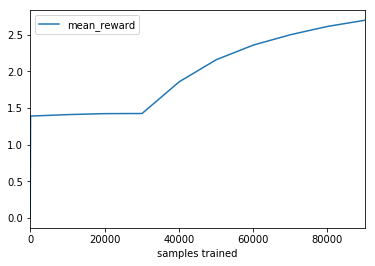

In [3]:
df.plot(x='samples trained', y='mean_reward')